In [1]:
from time import time
from datetime import datetime
from contextlib import contextmanager
from collections import namedtuple
import numpy as np
import matplotlib.pyplot as plt
import nest
import world
from world_populations import Planner, Cortex

from cerebellum import MF_number, define_models, \
        create_forward_cerebellum, create_inverse_cerebellum
import trajectories

In [2]:
Brain = namedtuple("Brain", "planner cortex forward inverse")

nest.Install("cerebmodule")
nest.Install("extracerebmodule")

trial_len = 300

In [3]:
def create_brain(prism):
    trajectories.save_file(prism, trial_len)

    define_models()
    cereb_inv = create_inverse_cerebellum()
    cereb_for = create_forward_cerebellum()
    # cereb_foo = create_forward_cerebellum()

    planner = Planner(MF_number, prism)
    cortex = Cortex(MF_number)

    planner.connect(cortex)

    # Forward model:
    # - motor input from the cortex (efference copy)
    # - sensory output to the cortex
    # - sensory error signal
    cortex.connect(cereb_for.mf)  # Efference copy

    fDCN = cereb_for.dcn
    conn_dict = {"rule": "fixed_indegree", "indegree": 1}
    nest.Connect(fDCN.plus.pop, cortex.pop, conn_dict, {'weight': 1.0})
    nest.Connect(fDCN.minus.pop, cortex.pop, conn_dict, {'weight': -1.0})

    # Inverse model;
    # - sensory input from planner
    # - motor output to world
    # - motor error signal
    planner.connect(cereb_inv.mf)  # Sensory input

    return cortex, cereb_for, cereb_inv

In [4]:
FORWARD = True
INVERSE = True

prism = 20.0
n_trials = 40

In [5]:
# Get reference x
nest.ResetKernel()
cortex, _, _ = create_brain(0.0)
xs = []

for i in range(10):
    nest.Simulate(trial_len)

    x = cortex.integrate(trial_i=i)
    if i >= 5:
        xs.append(x)

ref_x = np.mean(xs)

In [6]:
# Get open loop error
nest.ResetKernel()
cortex, _, _ = create_brain(prism)
xs = []

for i in range(10):
    nest.Simulate(trial_len)

    x = cortex.integrate(trial_i=i)
    if i >= 5:
        xs.append(x)

mean = np.mean(xs)
open_loop_error, std_deg = world.get_error(ref_x, mean)

print("Open loop error:", open_loop_error)

Open loop error: 20.552739092785025


In [7]:
def get_weights(pop1, pop2):
    conns = nest.GetConnections(pop1[::50], pop2[::50])
    weights = nest.GetStatus(conns, "weight")
    return weights

In [8]:
error_history = []

weights_for = []
weights_inv = []

In [9]:
nest.ResetKernel()
cortex, cereb_for, cereb_inv = create_brain(prism)
sensory_error = open_loop_error

In [10]:
for i in range(n_trials):
    if FORWARD:
        cereb_for.io.set_rate(sensory_error)
    if INVERSE:
        cereb_inv.io.set_rate(sensory_error, trial_i=i)

    print("Simulating")
    nest.Simulate(trial_len)
    print()
    print("Trial ", i+1)
    print()

    x_cortex = cortex.integrate(trial_i=i)

    if INVERSE:
        cereb_inv.dcn.plus.integrate(trial_i=i)
        cereb_inv.dcn.minus.integrate(trial_i=i)

        x_dcnp, _ = cereb_inv.dcn.plus.get_final_x()
        x_dcnn, _ = cereb_inv.dcn.minus.get_final_x()

        print("Contributions from inverse DCN:")
        print("Positive:", x_dcnp)
        print("Negative:", x_dcnn)

        x_sum = x_cortex + x_dcnp - x_dcnn
    else:
        x_sum = x_cortex

    sensory_error, std_deg = world.get_error(ref_x, x_sum)
    error_history.append(sensory_error)
    print("Closed loop error %d:" % i, sensory_error)

    if FORWARD:
        print()
        print("Forward IO: %.1f" % cereb_for.io.get_per_trial_rate())
        print("Forward MF: %.1f" % cereb_for.mf.get_per_trial_rate())
        print("Forward GR: %.1f" % cereb_for.gr.get_per_trial_rate())
        print("Forward PC: %.1f" % cereb_for.pc.get_per_trial_rate())
        print("Forward DCN: %.1f" % cereb_for.dcn.get_per_trial_rate())

        weights = get_weights(cereb_for.gr.pop, cereb_for.pc.pop)
        weights_for.append(weights)
        print("Forward PFPC weights:", min(weights), "to", max(weights))

    if INVERSE:
        print()
        print("Inverse IO: %.1f" % cereb_inv.io.get_per_trial_rate())
        print("Inverse MF: %.1f" % cereb_inv.mf.get_per_trial_rate())
        print("Inverse GR: %.1f" % cereb_inv.gr.get_per_trial_rate())
        print("Inverse PC: %.1f" % cereb_inv.pc.get_per_trial_rate())
        print("Inverse DCN: %.1f" % cereb_inv.dcn.get_per_trial_rate())

        weights = get_weights(cereb_inv.gr.pop, cereb_inv.pc.pop)
        weights_inv.append(weights)
        print("Inverse PFPC weights:", min(weights), "to", max(weights))

Simulating

Trial  1

Contributions from inverse DCN:
Positive: 1.5309917355371903
Negative: 1.9545454545454548
Closed loop error 0: 15.709418297840955

Forward IO: 10.8
Forward MF: 42.8
Forward GR: 8.6
Forward PC: 172.7
Forward DCN: 0.0
Forward PFPC weights: 15.95907558813507 to 18.59999999999999

Inverse IO: 12.0
Inverse MF: 45.5
Inverse GR: 3.7
Inverse PC: 91.2
Inverse DCN: 6.1
Inverse PFPC weights: 9.81182337757183 to 16.799999999999997
Simulating

Trial  2

Contributions from inverse DCN:
Positive: 0.0
Negative: 0.0
Closed loop error 1: 17.652038279198305

Forward IO: 7.3
Forward MF: 45.1
Forward GR: 9.2
Forward PC: 182.7
Forward DCN: 2.0
Forward PFPC weights: 1.4 to 19.999999999999986

Inverse IO: 8.7
Inverse MF: 46.0
Inverse GR: 3.7
Inverse PC: 88.3
Inverse DCN: 14.2
Inverse PFPC weights: 1.312036584591907 to 16.999999999999996
Simulating

Trial  3

Contributions from inverse DCN:
Positive: 0.0
Negative: 0.0
Closed loop error 2: 15.65772224562743

Forward IO: 10.7
Forward MF: 43


Trial  23

Contributions from inverse DCN:
Positive: 0.0
Negative: 0.0
Closed loop error 22: 11.869955861565323

Forward IO: 3.0
Forward MF: 41.0
Forward GR: 7.5
Forward PC: 142.3
Forward DCN: 3.6
Forward PFPC weights: 0.0 to 30.0

Inverse IO: 5.5
Inverse MF: 45.6
Inverse GR: 3.7
Inverse PC: 61.1
Inverse DCN: 27.0
Inverse PFPC weights: 0.0 to 21.861140780912763
Simulating

Trial  24

Contributions from inverse DCN:
Positive: 0.0
Negative: 0.0
Closed loop error 23: 8.79204889752334

Forward IO: 6.8
Forward MF: 39.8
Forward GR: 7.1
Forward PC: 132.9
Forward DCN: 6.0
Forward PFPC weights: 0.0 to 30.0

Inverse IO: 6.7
Inverse MF: 44.9
Inverse GR: 3.6
Inverse PC: 55.5
Inverse DCN: 22.6
Inverse PFPC weights: 0.2 to 22.061140780912762
Simulating

Trial  25

Contributions from inverse DCN:
Positive: 0.0
Negative: 0.0
Closed loop error 24: 8.092916684710413

Forward IO: 4.0
Forward MF: 39.4
Forward GR: 6.6
Forward PC: 124.4
Forward DCN: 4.9
Forward PFPC weights: 0.0 to 30.0

Inverse IO: 6.2
In

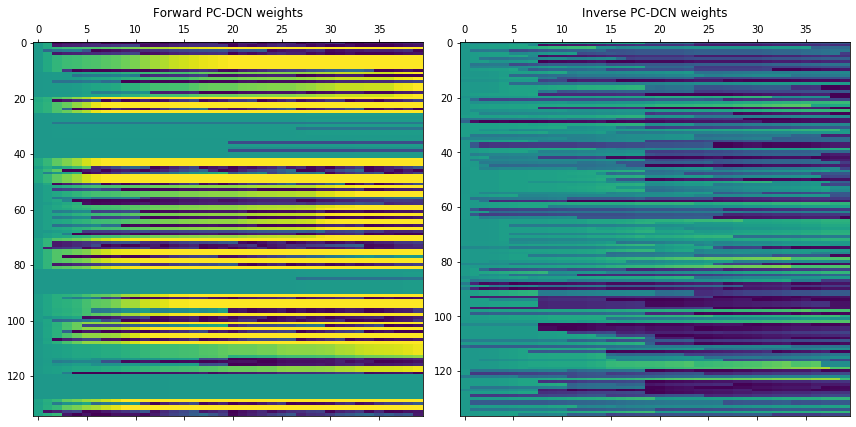

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(12,6))

w_max = np.max([np.max(weights_for), np.max(weights_inv)])

axs[0].set_title("Forward PC-DCN weights")
axs[0].matshow(np.transpose(weights_for), aspect='auto', vmin=0.0, vmax=30)

axs[1].set_title("Inverse PC-DCN weights")
axs[1].matshow(np.transpose(weights_inv), aspect='auto', vmin=0.0, vmax=30)

plt.tight_layout()
plt.show()

fig.savefig("weights_40.pdf", bbox_inches='tight')
fig.savefig("weights_40.png", bbox_inches='tight')

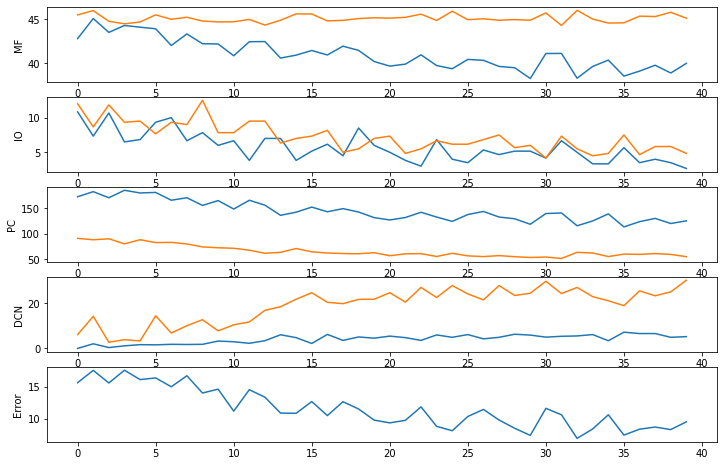

In [13]:
fig, axs = plt.subplots(5, figsize=(12,8))

if FORWARD:
    cereb_for.mf.plot_per_trial_rates('MF', axs[0])
    cereb_for.io.plot_per_trial_rates('IO', axs[1])
    cereb_for.pc.plot_per_trial_rates('PC', axs[2])
    cereb_for.dcn.plot_per_trial_rates('DCN', axs[3])

if INVERSE:
    cereb_inv.mf.plot_per_trial_rates('MF', axs[0])
    cereb_inv.io.plot_per_trial_rates('IO', axs[1])
    cereb_inv.pc.plot_per_trial_rates('PC', axs[2])
    cereb_inv.dcn.plot_per_trial_rates('DCN', axs[3])

axs[4].set_ylabel('Error')
axs[4].plot(error_history)
plt.show()

fig.savefig("rates_40.pdf", bbox_inches='tight')
fig.savefig("rates_40.png", bbox_inches='tight')

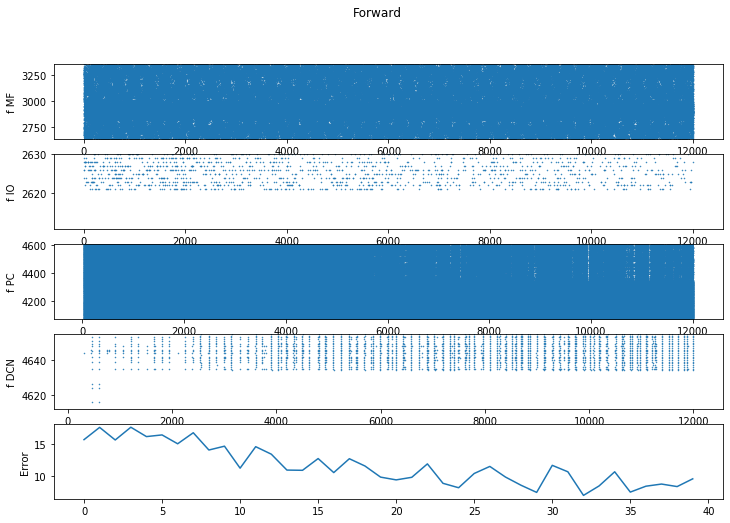

In [14]:
if FORWARD:
    fig, axs = plt.subplots(5, figsize=(12,8))
    fig.suptitle("Forward")

    cereb_for.mf.plot_spikes('f MF', axs[0])
    cereb_for.io.plot_spikes('f IO', axs[1])
    cereb_for.pc.plot_spikes('f PC', axs[2])
    cereb_for.dcn.plot_spikes('f DCN', axs[3])

    axs[4].set_ylabel('Error')
    axs[4].plot(error_history)
    plt.show()
    
    fig.savefig("forward_spikes_40.pdf", bbox_inches='tight')
    fig.savefig("forward_spikes_40.png", bbox_inches='tight')

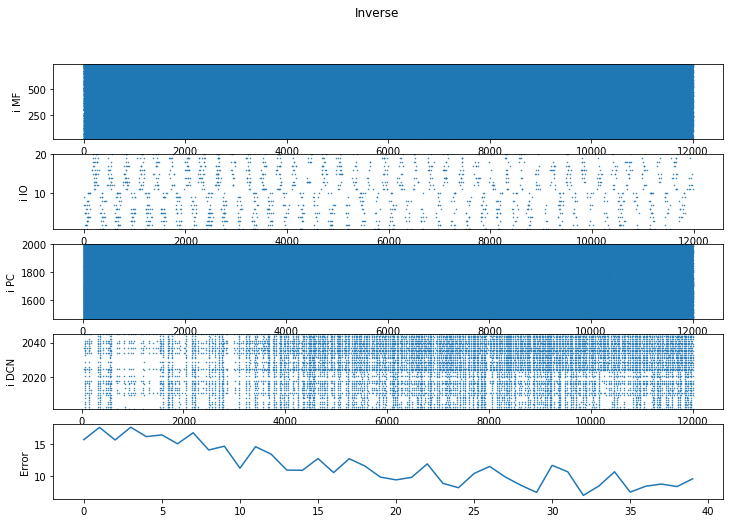

In [15]:
if INVERSE:
    fig, axs = plt.subplots(5, figsize=(12, 8))
    fig.suptitle("Inverse")

    cereb_inv.mf.plot_spikes('i MF', axs[0])
    cereb_inv.io.plot_spikes('i IO', axs[1])
    cereb_inv.pc.plot_spikes('i PC', axs[2])
    cereb_inv.dcn.plot_spikes('i DCN', axs[3])

    axs[4].set_ylabel('Error')
    axs[4].plot(error_history)
    plt.show()
    
    fig.savefig("inverse_spikes_40.pdf", bbox_inches='tight')
    fig.savefig("inverse_spikes_40.png", bbox_inches='tight')